In [40]:
# RestNet(Skip connection, Regidual Block) 잔차를 레이어에 더해준다

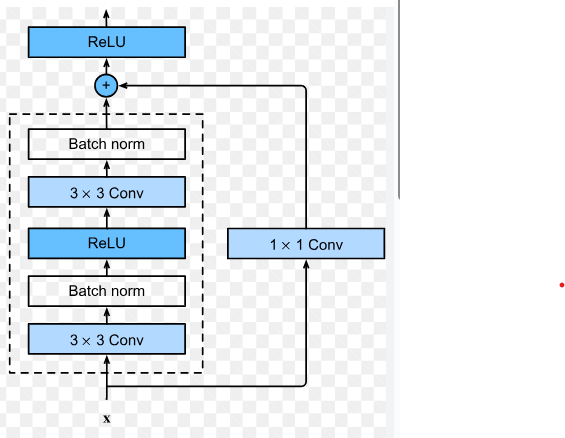

In [41]:
#conv - batchn- Relu- conc - batchn
import torch.nn as nn
import torch
conv1 = nn.Conv2d(3,32,kernel_size=3, padding=1)
batch1 = nn.BatchNorm2d(32) #출력값 받음
relu = nn.ReLU()
conv2 = nn.Conv2d(32,64,kernel_size=3, padding=1)
batch2 = nn.BatchNorm2d(64)
X = torch.randn(2,3,32,32)
X_ = X #스킵커넥션을 위해서 초기 입력을 저장
X = conv1(X)
X =relu(X)
X = conv2(X)
X = batch2(X)
X.size(), X_.size()
#다통과했을때 모양, 최초의 모양

(torch.Size([2, 64, 32, 32]), torch.Size([2, 3, 32, 32]))

In [42]:
downsample = nn.Conv2d(3,64,kernel_size=1)
down_X = downsample(X_)
down_X.size()


torch.Size([2, 64, 32, 32])

In [43]:
import torch
import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self, in_channel,out_channel,hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel,hidden_dim,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(hidden_dim,out_channel,kernel_size=3,padding=1)
        self.batch1 = nn.BatchNorm2d(hidden_dim)
        self.batch2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.downsample = nn.Conv2d(in_channel,out_channel,kernel_size=1)
    def forward(self, x):
        x_ = x
        x_ = self.downsample(x_)

        x = self.relu(self.batch1(self.conv1(x)))
        x = self.batch2(self.conv2(x))        
        x += x
        out = self.relu(x)
        return out

In [44]:
sample = torch.randn(1,256,32,32)
t = BasicBlock(256,256,256)
t(sample).size() 

torch.Size([1, 256, 32, 32])

In [45]:
class ResNet(nn.Module):
    def __init__(self, class_num = 10):
        super(ResNet,self).__init__()
        self.b1 = BasicBlock(3,64,32) 
        self.b2 = BasicBlock(64,256,128)
        self.b3 = BasicBlock(256,256,256)

        self.pool = nn.AvgPool2d(2)

        self.fc1 = nn.Linear(256*4*4 , 2048) 
        self.fc2 = nn.Linear(2048 , 512)
        self.fc3 = nn.Linear(512 , class_num)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
    def forward(self,x):
        x =  self.dropout1(self.b1(x))  
        x = self.dropout1(self.b2(x))  
        x = self.dropout2 (self.b3(x)) 
        x = torch.flatten(x, start_dim=1)             
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)

        return out

In [46]:
sample = torch.randn(1,3,32,32)
model = ResNet(2)
test = model(sample)
test.size()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x262144 and 4096x2048)

In [ ]:
# 데이터는 인간 - 말
# 학습 - 평가

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset =  datasets.ImageFolder(root = r'D:\skn_20\deep-learning\train', transform=transform)
test_dataset =  datasets.ImageFolder(root = r'D:\skn_20\deep-learning\test', transform=transform)
train_loader = DataLoader(train_dataset,batch_size=5,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=5,shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(2)
model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epochs = 20
# 학습루프
for epoch in range(epochs):
    tqdm_obj = tqdm(train_loader,desc=f'epoch : {epoch+1}/{epochs}')
    for data, label in tqdm_obj:
        optim.zero_grad()
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()

        tqdm_obj.set_postfix(loss=loss.item())
        

torch.save(model.state_dict(), 'resnet.pth')    
        

torch.save(model.state_dict(), 'resnet.pth')    

epoch : 20/20: 100%|██████████| 206/206 [00:31<00:00,  6.52it/s, loss=0]       


In [ ]:
# 평가
model.load_state_dict(torch.load('resnet.pth',map_location=device,weights_only=True))
# 예측
# 평가 루프
# test_loader가 이미 정의되어 있다고 가정
model.eval()  # 평가 모드로 전환 (dropout, batchnorm 등 비활성화)
total_loss = 0.0
total_correct = 0
total_samples = 0

criterion = nn.CrossEntropyLoss()
with torch.no_grad():  # 그래디언트 계산 비활성화
    for data, label in tqdm(test_loader, desc="Evaluating"):
        data, label = data.to(device), label.to(device)
        preds = model(data)
        loss = criterion(preds, label)
        total_loss += loss.item() * data.size(0)  # 배치 손실 합산
        total_correct += (preds.argmax(dim=1) == label).sum().item()
        total_samples += data.size(0)

avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")


Evaluating: 100%|██████████| 52/52 [00:05<00:00, 10.37it/s]

Test Loss: 1.7524, Test Accuracy: 0.8945


In [ ]:
from torchvision.models.resnet import resnet50
resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 